# Picking Up Where We Left Off
If you did not read the previous post then I would recommend reading about the [inspiration](https://orgulo.us/posts/nbks/2022-12-16-valorant-color-crosshair.html) for the post and how we got here. In fact, I strongly recommend it since I'm going to be skipping some of the basic discussion and hopping right into getting other maps working.

# What About Other Solutions?
I talked about how I was not the first person to come across this idea. In fact, there is a post on [Reddit](https://www.reddit.com/r/VALORANT/comments/x3ok8b/optimal_crosshair_colors_based_on_customs_game/?utm_term=2001568619&utm_medium=post_embed&utm_source=embed&utm_name=&utm_content=header) along with the [code](https://github.com/useewhynot/Valorant_Optimal_Crosshair) they used to come to their conclusions.

> I collected the videos by running around in customs without a crosshair and recording the video with OBS; you could get colors from game files but I'm not nearly that smart. 

I thought this was probably fine. In fact, removing the UI elements would help with keeping the contamination of the UI down. Realistically, this should not have much negative impact but if we're going for optimal then removing them would be best. If Valorant a had replay system, this could be better as I actually prefer my method of taking real footage from top level players. My method uses real data from a real player looking realistically at the different maps. However, since mine is taken from a Twitch recording then the webcam included is contamination. We could help limit this data from using other players with and without web cams though so if we wanted to take this a bit further.

> From there I used OpenCV to load each video frame by frame, then used PIL and K-Means to extract the dominant color from a specific cropped section of the image (usually a square crop around the center of the image). This color was then collected for every frame in the map and averaged to get the overall "color of the map".

Again, I like part of this and dislike another part. Using OpenCV was just a better idea. For my data, I had to export all the images from the video using ffmpeg and then categorize them manually frame by frame. If I had used video editing software to clip the footage apart with a naming conventions for the different maps then import and iterating through the data would be much easier. Kudos.

I strongly dislike the cropping for this project; this is not representative of what a normal player would see while interacting with a map. Much of higher level play is about forcing players to adjust their crosshair by the angles/heights taken by your position and this method will throw out a lot of useful information. K-Means is probably fine but likely unnecessary.

>  From here, I just inverted the color and maximized the saturation and value of the color to make it as bright as possible. I'm not a color person, so it's entirely possible this is a super bad choice, but idk. It'd be cool to see how considering multiple dominant colors per frame, or weighting specific important frames (e.g. big angles) more would impact the decisions, but I'm overthinking this enough as it is.

I would criticize this but I am also not a color person so who am I to judge here?


# Working On The Other Maps
Currently, I do not have a collection of all the maps but I have a solid number of them to work with. Due to Riots requirements to even install and play the game, I am not able to collect any data myself. And thus, with the permission of Alex who was kind enough to allow me to use his streams as a data source, I have to collect and label them manually leading to me missing some maps currently. We'll get our imports and pull our data that I already had and labeled.

In [2]:
import torch
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from torchvision.io import read_image

In [4]:
#| echo: false
dataDirectory = Path('/run/media/shoklan/b0cd1179-316d-4515-88eb-b16657e8d18a/Images/Alex/images/')
# We fixed the filenames in the last post.
imageSolutions = pd.read_csv(dataDirectory/'alexImages.csv')

The Data Class work from the last post was fun but we'll need something better this time around. We don't want to only do this for a single map but in fact calculate the average over all the collected maps. Looking at our problem, we need:
1. Samples grouped by each map.
2. A function to summarize the image data.

Thankfully, there is a way to easily solve the first problem: `groupby()`. This function takes a column and then creates a subgroup based on the values in that column.
In our example, we'll be grouping the filenames by the `map` name so when we collect the image data then the results will be done *per map*.

In [6]:
imageSolutions.groupby('map').count().T

map,Ascent,Bind,Breeze,Haven,Icebox,Menu,Other,Range
image,12766,8882,9629,10535,1985,7577,879,1025


This *groupby* object needs some kind of **aggregation** function - like `count()` above - to be useful. Common functions would be `count()`, `sum()` and `mean()`. Before we deal with our own custom function, we need to get the sample part working. Thankfully, this is also just as easy since pandas has a `sample()` function for this.

In [152]:
imageSolutions.groupby('map').sample(100).value_counts('map')

map
Ascent    100
Bind      100
Breeze    100
Haven     100
Icebox    100
Menu      100
Other     100
Range     100
dtype: int64

With the number of observations that we have then reasonable sample size of 500 images per map should work for our testing.
We also don't need the `menu`, `range` or `other` categories so we'll also drop those.

In [7]:
ignore = ['Other', 'Range', 'Menu']
mapSubset = imageSolutions.groupby('map').sample(500).query("map != @ignore")
mapSubset

,image,map
26270,alex26271.png,Ascent
41785,alex41786.png,Ascent
44429,alex44430.png,Ascent
25324,alex25325.png,Ascent
46256,alex46257.png,Ascent
...,...,...
293,alex00294.png,Icebox
744,alex00745.png,Icebox
1987,alex01988.png,Icebox
1968,alex01969.png,Icebox


## Image Average Function
We already went over how to read an image but we'll do it again. Pytorch has the function `read_image()` to read an image into a torch tensor. And, we'll need to adjust the dimensions so we can see the images.

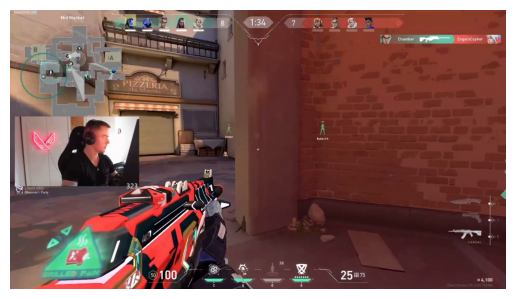

In [170]:
plt.axis('off')
plt.imshow(read_image(str(dataDirectory/mapSubset.image.iloc[0])).moveaxis(0,2));
# Hi Alex!


We are going to keep using the mean since this is acceptable for our use case. Calculating this is simple enough:

In [187]:
read_image(str(dataDirectory/mapSubset.image.iloc[0])).moveaxis(0,2).numpy().mean(axis=(0,1))

array([109.47447097,  69.39480131,  63.72558256])

Perfect. So, now we have all the pieces we need to calcuate the mean image per map.

In [200]:
mapColors = mapSubset.groupby('map', group_keys=True)\
    .apply(lambda x:
        tuple(
            read_image(
            str(dataDirectory/x.image.values[0])).moveaxis(0,2).numpy().mean(axis=(0,1))
        )
)

for i,color in enumerate(mapColors):
    print(f"The Map {mapColors.index[i]} has a mean color of {color}")

The Map Ascent has a mean color of (109.4744709683642, 69.3948013117284, 63.725582561728395)
The Map Bind has a mean color of (114.81199025848765, 113.48977719907407, 130.3785411844136)
The Map Breeze has a mean color of (113.30181327160494, 91.05116560570988, 93.52008969907408)
The Map Haven has a mean color of (72.52671730324074, 57.23288917824074, 59.851847993827164)
The Map Icebox has a mean color of (94.04369695216049, 86.80147665895062, 83.2131568287037)


Those tuples are not of much value so we will convert them into images and show them all off.


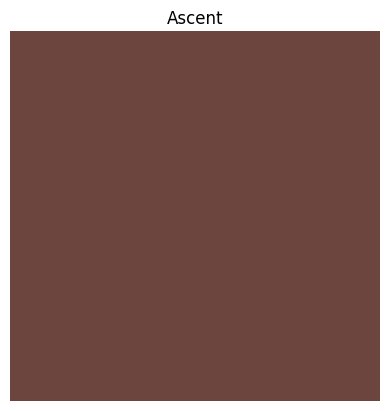

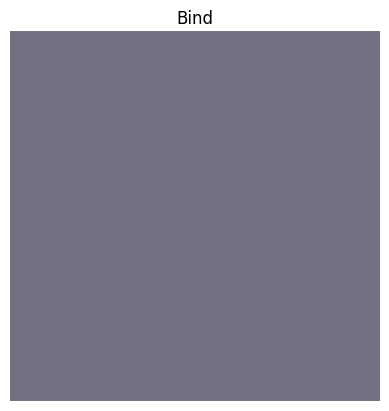

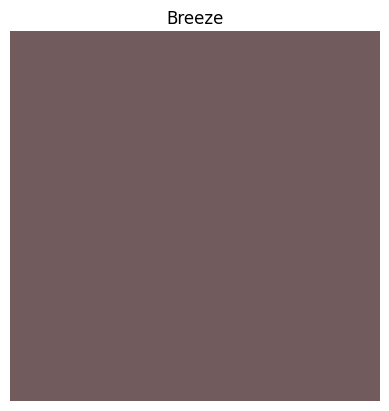

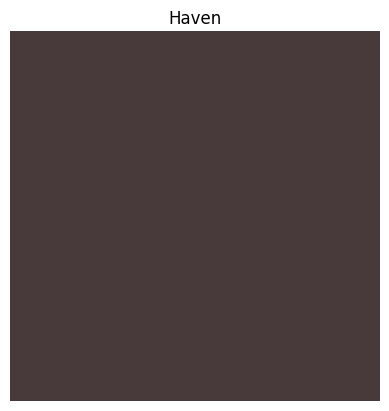

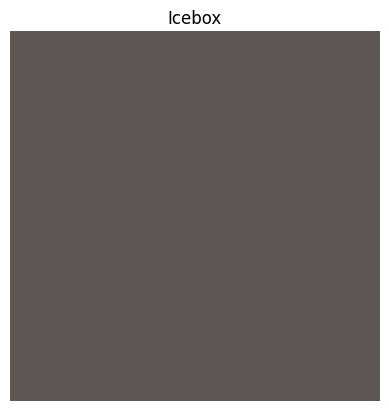

In [272]:
from matplotlib import pyplot
for i,color in enumerate(mapColors):
    height, width, channels = 100, 100, 3
    image_blank_new = np.zeros((height, width, channels), np.uint8)
    image_blank_new[::] = color
    plt.axis('off')
    plt.title(mapColors.index[i])
    pyplot.imshow(image_blank_new)
    pyplot.show()

I notice that our Icebox is not the same result as we got last time. Perhaps in another post we'll explore the why for that. What we need to do now is take the color data and create a high contrast color as we had done before. We'll go ahead and do this per map and we can reuse the for loop for this.

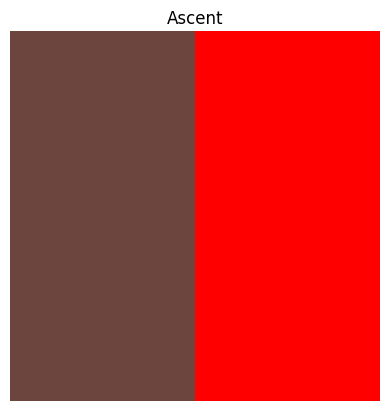

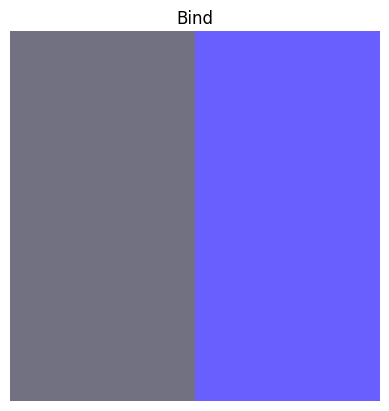

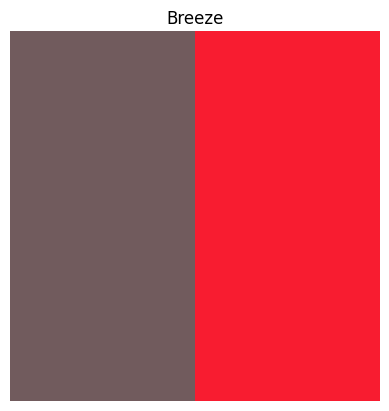

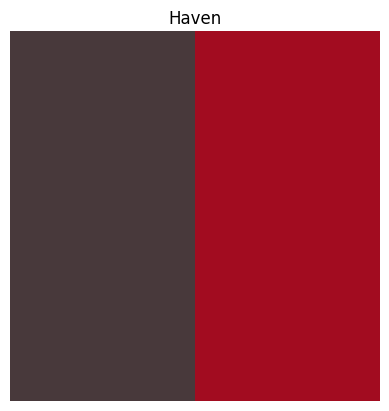

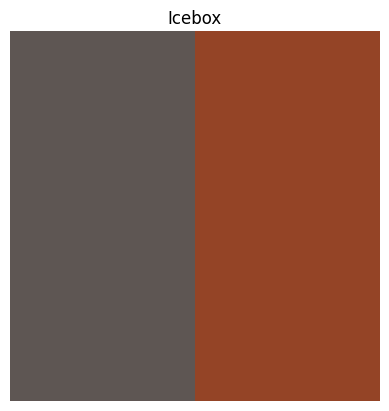

In [278]:
from PIL import ImageEnhance

for i,color in enumerate(mapColors):
    # Generate the initial image
    height, width, channels = 100, 100, 3
    image_blank_new = np.zeros((height, width, channels), np.uint8)
    image_blank_new[::] = color

    # Enhance the contrast
    im_new = Image.fromarray(image_blank_new)
    imC_new = ImageEnhance.Contrast(im_new).enhance(10)

    # Generate the comparison image
    image_blank_final = np.zeros((height, width, channels), np.uint8)
    image_blank_final[0:100,0:50] = color
    image_blank_final[0:100,50:100] = np.array(imC_new)[0][0]

    # Plotting part:
    plt.axis('off');
    plt.title(mapColors.index[i]);
    pyplot.imshow(image_blank_final);
    pyplot.show();

And, lastly we'll get the RGB values for the colors in case anyone wants to try this out!

In [281]:
from matplotlib.colors import rgb2hex

for i,color in enumerate(mapColors):
    height, width, channels = 100, 100, 3
    image_blank_new = np.zeros((height, width, channels), np.uint8)
    image_blank_new[::] = color
    cxColor = rgb2hex(np.array(image_blank_new).mean(axis=0)[0]/255)
    print(f"Use the crosshair color {cxColor} for {mapColors.index[i]}")

Use the crosshair color #6d453f for Ascent
Use the crosshair color #727182 for Bind
Use the crosshair color #715b5d for Breeze
Use the crosshair color #48393b for Haven
Use the crosshair color #5e5653 for Icebox


# Conclusions
There we go! <br />
Try them out and see if they work!